# Collaborative filtering for Movie Recommendation

## Importing pre-processed data

In [1]:
import pandas as pd

### Movie information

In [2]:
movies_df = pd.read_csv("data/ml-latest-small-preprocessed/movies.csv")

movies_df.head()

,movieId,title,year_1980s,year_1990.0-1994.0,year_1995.0-1999.0,year_2000.0-2004.0,year_2005.0-2009.0,year_2010.0-2014.0,year_2015+,year_pre-1980,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Ratings information

In [3]:
ratings_df = pd.read_csv("data/ml-latest-small-preprocessed/ratings.csv")

ratings_df.head()

,userId,movieId,rating,timestamp,percentile,relevant
0,1,1,0.777778,964982703,0.518238,0
1,1,3,0.777778,964981247,0.518238,0
2,1,6,0.777778,964982224,0.518238,0
3,1,47,1.000000,964983815,0.868995,1
4,1,50,1.000000,964982931,0.868995,1


## Collaborative filtering

### Evaluation suite

In [4]:
from pandas import DataFrame
from recommender.collaborative_filtering import CollaborativeFilter, get_all_recommendations
from recommender.evaluation import evaluation, evaluate_rating_predictions, count_recommendations 

def test_one_split(ratings_train: DataFrame,
                   ratings_test: DataFrame,
                   k_values: list = [5, 10],
                   components: int = 20,
                   iterations: int = 10) -> DataFrame:
    """
    Test one train/test split using collaborative filtering
    """
    # Create and fit collaborative filtering model
    
    cf_model = CollaborativeFilter(n_components = components, n_iter = iterations)
    cf_model.fit(ratings_train)
    
    all_recommendations = get_all_recommendations(
        cf_model,
        ratings_train,
        ratings_test
    )
    
    rec_counts = count_recommendations(all_recommendations, k=5)
    
    rank_results = evaluation(
        all_recommendations,
        ratings_test,
        k_values
    )
    
    rating_metrics = evaluate_rating_predictions(
        cf_model,
        ratings_test,
        metrics=['rmse', 'mae']
    )
    
    return rank_results, rating_metrics, rec_counts

### (Stratified) k-fold cross validation suite

#### Parameters

In [5]:
n_splits = 10
k_values = list(range(1,11))
components = 20
iterations = 40

In [6]:
from recommender.stratified_kfold import stratified_kfold_split

splits = stratified_kfold_split(ratings_df, 
                                target_column = "userId",
                                n_splits = n_splits,
                                shuffle = True,
                                random_state = 1337)
results_list = []
metrics_list = []
rec_counts_list = []

for i in range(n_splits):
    print(f"Evaluating split {i}")
    ratings_train = pd.concat([splits[j] for j in range(n_splits) if j != i])
    ratings_test = splits[i]
    
    result_i, metrics_i, counts_i = test_one_split(ratings_train, ratings_test, k_values, components, iterations)
    result_i["split"] = i
    
    results_list.append(result_i)
    metrics_list.append(metrics_i)
    rec_counts_list.append(counts_i)



Evaluating split 0
Evaluating split 1
Evaluating split 2
Evaluating split 3
Evaluating split 4
Evaluating split 5
Evaluating split 6
Evaluating split 7
Evaluating split 8
Evaluating split 9


In [7]:
results = pd.concat(results_list, axis=0, ignore_index=True)
metrics = pd.concat(metrics_list, axis=0, ignore_index=True)

In [8]:
results.to_csv("data/collaborative-filtering.csv", index = False)
metrics.to_csv("data/collaborative-filtering.csv", index = False)

In [9]:
total_rec_counts = pd.concat(rec_counts_list, axis=1).fillna(0).sum(axis=1)

rec_counts_df = pd.DataFrame({
    'movieId': total_rec_counts.index,
    'rec_count': total_rec_counts.values
}).sort_values('rec_count', ascending=False)

rec_counts_df = rec_counts_df.merge(
        movies_df[['movieId', 'title']], 
        on='movieId'
    )

### Plotting results

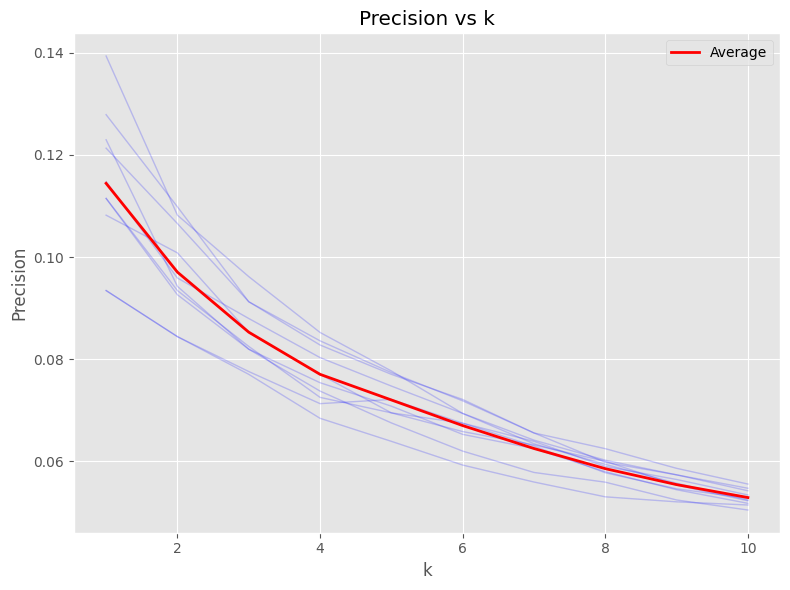

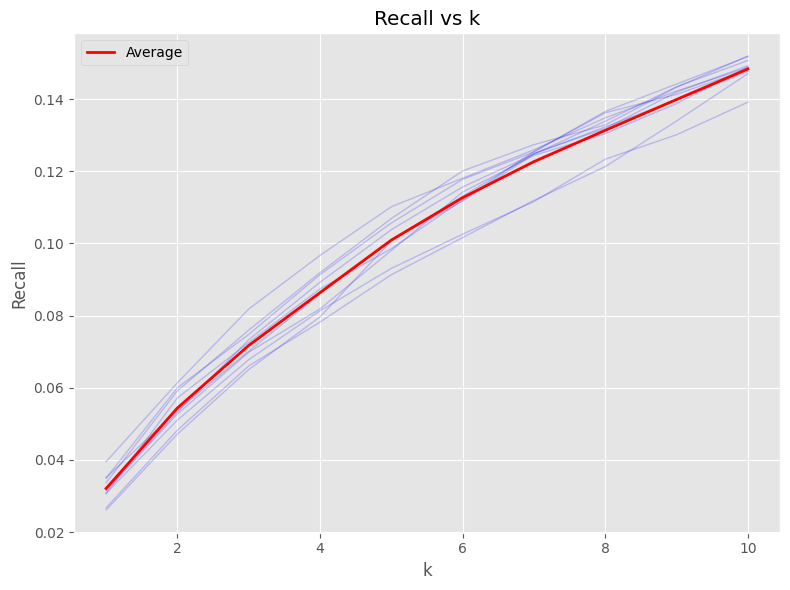

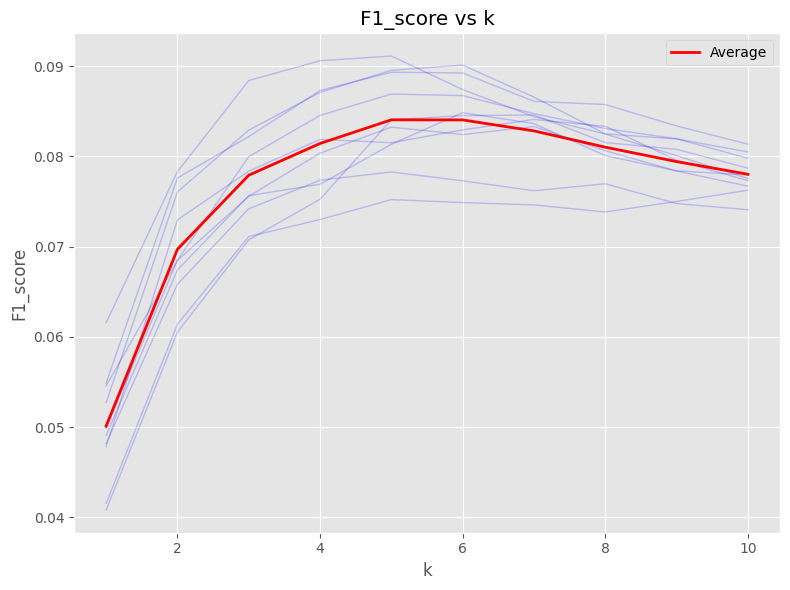


Metrics for k=5:
Precision: 0.0720 ± 0.0046
Recall: 0.1009 ± 0.0060
F1_score: 0.0841 ± 0.0052

Metrics for k=10:
Precision: 0.0529 ± 0.0016
Recall: 0.1484 ± 0.0036
F1_score: 0.0780 ± 0.0022


In [10]:
import matplotlib.pyplot as plt

# Set style
plt.style.use('ggplot')
plot_metrics = ['precision', 'recall', 'f1_score']

# Create separate plot for each metric
for metric in plot_metrics:
    plt.figure(figsize=(8, 6))
    
    # Plot individual split lines (thin, transparent)
    for split in results['split'].unique():
        split_data = results[results['split'] == split]
        plt.plot(split_data['k'], split_data[metric], 
                alpha=0.2, color='blue', linewidth=1)
    
    # Plot average line (thick, solid)
    avg_by_k = results.groupby('k')[metric].mean()
    plt.plot(avg_by_k.index, avg_by_k.values, 
            linewidth=2, color='red', label='Average')
    
    plt.title(f'{metric.capitalize()} vs k')
    plt.xlabel('k')
    plt.ylabel(metric.capitalize())
    plt.grid(True)
    plt.legend()
    
    # Optional: Adjust layout and save
    plt.tight_layout()
    # plt.savefig(f'{metric}_vs_k.png', dpi=300, bbox_inches='tight')
    plt.show()

# Print metrics for k=5 and k=10
for k in [5, 10]:
    print(f"\nMetrics for k={k}:")
    k_results = results[results['k'] == k]
    for metric in plot_metrics:
        mean_val = k_results[metric].mean()
        std_val = k_results[metric].std()
        print(f"{metric.capitalize()}: {mean_val:.4f} ± {std_val:.4f}")

### Printing rating prediction metrics

In [11]:
metrics

,rmse,mae
0,0.177146,0.118252
1,0.176580,0.117751
2,0.177319,0.117290
3,0.174779,0.116420
4,0.177328,0.118189
5,0.176066,0.117496
6,0.177249,0.118402
7,0.179174,0.118278
8,0.176010,0.117039
9,0.177005,0.118156


In [12]:
print("\nRating Prediction Metrics:")
print("-" * 50)

for column in metrics.columns:
    mean_val = metrics[column].mean()
    std_val = metrics[column].std()
    print(f"{column.upper()}: {mean_val:.4f} ± {std_val:.4f}")


Rating Prediction Metrics:
--------------------------------------------------
RMSE: 0.1769 ± 0.0011
MAE: 0.1177 ± 0.0007


### Plotting recommendation distribution

Recommendation Statistics:
count      81.000000
mean      376.543210
std       788.053838
min         1.000000
25%         5.000000
50%        30.000000
75%       281.000000
max      3149.000000
Name: rec_count, dtype: float64


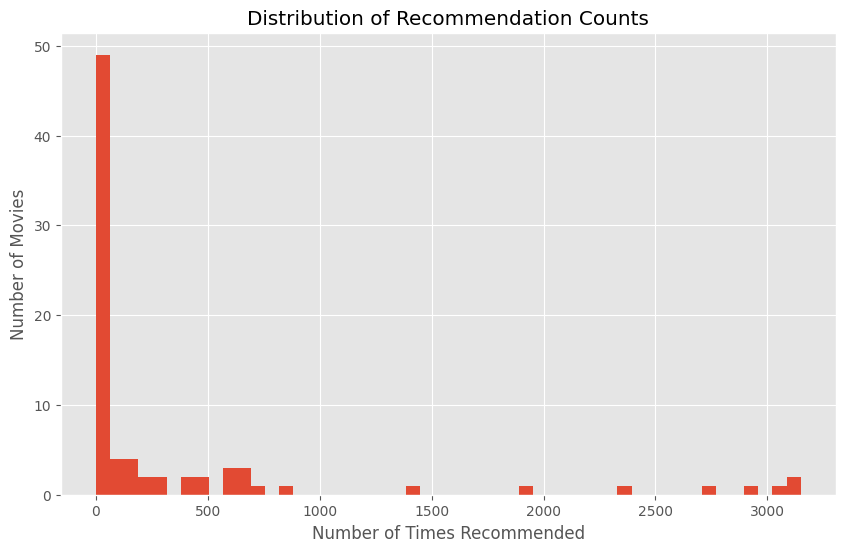


Top 10 Most Recommended Movies:
   movieId  rec_count                                              title
0      296     3149.0                                Pulp Fiction (1994)
1      260     3110.0          Star Wars: Episode IV - A New Hope (1977)
2      356     3025.0                                Forrest Gump (1994)
3      318     2932.0                   Shawshank Redemption, The (1994)
4     2571     2737.0                                 Matrix, The (1999)
5      593     2364.0                   Silence of the Lambs, The (1991)
6     1196     1927.0  Star Wars: Episode V - The Empire Strikes Back...
7     2959     1449.0                                  Fight Club (1999)
8      589      874.0                  Terminator 2: Judgment Day (1991)
9     1210      741.0  Star Wars: Episode VI - Return of the Jedi (1983)


In [16]:
print("Recommendation Statistics:")
print(rec_counts_df['rec_count'].describe())

# Plot distribution
plt.figure(figsize=(10, 6))
plt.hist(rec_counts_df['rec_count'], bins=50)
plt.title('Distribution of Recommendation Counts')
plt.xlabel('Number of Times Recommended')
plt.ylabel('Number of Movies')
plt.show()

# Show top 10 most recommended movies
print("\nTop 10 Most Recommended Movies:")
print(rec_counts_df.head(10))

### Usage example

In [14]:
def user_id_recommend(user_id: int,
                      ratings_df: DataFrame,
                      movies_df: DataFrame,
                      k: int = 5):
    """
    Demonstrate collaborative filtering recommendations for a user
    
    Parameters:
    - user_id: ID of the user to get recommendations for
    - ratings_df: Complete ratings DataFrame
    - movies_df: Movies DataFrame
    - k: Number of recommendations to show
    """
    # Get one split from stratified k-fold
    splits = stratified_kfold_split(ratings_df, 'userId', n_splits=5, shuffle=True, random_state=42)
    train_ratings = pd.concat([splits[i] for i in range(1, 5)])
    
    # Get user's actual ratings
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    print(f"\nUser {user_id}'s top rated movies:")
    top_rated = user_ratings.nlargest(5, 'rating')
    for _, row in top_rated.iterrows():
        movie_title = movies_df[movies_df['movieId'] == row['movieId']]['title'].iloc[0]
        print(f"- {movie_title} (Rating: {row['rating']:.1f})")
    
    # Create and fit collaborative filtering model
    cf_model = CollaborativeFilter(n_components=20)
    cf_model.fit(train_ratings)
    
    # Get recommendations
    watched_movies = set(user_ratings['movieId'])
    recommendations = cf_model.get_recommendations(user_id, exclude_movies=watched_movies)
    
    print(f"\nTop {k} recommended movies:")
    top_k_recs = recommendations.head(k)
    for _, row in top_k_recs.iterrows():
        movie_title = movies_df[movies_df['movieId'] == row['movieId']]['title'].iloc[0]
        print(f"- {movie_title} (Score: {row['similarity_score']:.3f})")

In [15]:
user_id_recommend(user_id=69,
                  ratings_df=ratings_df,
                  movies_df=movies_df,
                  k=5)


User 69's top rated movies:
- Usual Suspects, The (1995) (Rating: 1.0)
- Star Wars: Episode IV - A New Hope (1977) (Rating: 1.0)
- Pulp Fiction (1994) (Rating: 1.0)
- Shawshank Redemption, The (1994) (Rating: 1.0)
- Tommy Boy (1995) (Rating: 1.0)

Top 5 recommended movies:
- Jurassic Park (1993) (Score: 753.385)
- Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) (Score: 735.839)
- Godfather, The (1972) (Score: 731.785)
- Saving Private Ryan (1998) (Score: 730.821)
- Fight Club (1999) (Score: 720.398)
